### Exploratory data analysis (10pts)

There are 5 parts in this notebook. 
For each analysis, we provide some examples for you to follow. Your task is to conduct your own analysis following the logics provided in the examples, maked as "Your task".
- **Part-0: Data Import and Merging**
    > Merge Economic Indicator (World GDP) with the web-scraped text data
    
- **Part-1: Data cleaning**
    > organize attributes into appripriate data types (e.g., numerical, categorical, datatime, text) <br>
    > missing value and outlier detection <br>
    
- **Part-2: Data overview**
    > check the #samples, #attributes <br>
    > attribute types <br>
    
- **Part-3: Data transformation**
    > normalize numerical data (gdp)<br>
    > transform text data: tokenization, stemming, and lemmatization <br>
    
- **Part-4: Feature engineering**
    > encode categorical data <br>
    > convert DataTime data <br>
    > text feature representation <br>

- **Part-5: Additional analysis**
    > create new features <br>
    > colinearty check <br>

In [1]:
import csv
import pandas as pd
import spacy
import re
import geograpy
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow
from dateutil import parser
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

### Part-0: Data Import and Merging

In [2]:

df_gdp = pd.read_csv('C:/Users/Victoria/OneDrive/文档/Dropbox/Machine Learning Python/Project/gdp.csv')

# Filter the DataFrame to keep only the row where 'Country Name' is 'World'
df_gdp = df_gdp[df_gdp['Country Name'] == 'World']

# Drop the unwanted columns and reassign the DataFrame
df_gdp = df_gdp.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])

# Now use melt() to reshape the DataFrame
df_gdp = df_gdp.melt(id_vars=['Country Name'],
                     var_name='Year',
                     value_name='gdp')
df_gdp = df_gdp.drop(columns=['Country Name'])
# Check the first few rows of the reshaped DataFrame
df_gdp.head()

,Year,gdp
0,1960,NaN
1,1961,3.772924
2,1962,5.375360
3,1963,5.194927
4,1964,6.564476


In [3]:
# Load the raw data CSV file into a DataFrame
df_text = pd.read_csv('text_combine.csv')

# Drop the 'url' column from the DataFrame in-place
df_text.drop(columns=['URL'], inplace=True)

# Get an overview of the top-n rows/samples
print(df_text.head())


                                               Title              Date  \
0  2024 Report of the Committee for Development P...      9 April 2024   
1  World Economic Situation and Prospects: April ...      1 April 2024   
2  World Economic Situation and Prospects: March ...  29 February 2024   
3  Innovation ecosystems: making intellectual pro...  19 February 2024   
4  A globally just transition: Perspectives from ...   5 February 2024   

                                         Description  
0  ADVANCE UNEDITED VERSION of the Report on the ...  
1  Given the strong interactions between domestic...  
2  Regional integration in West African economies...  
3  CDP members will address intellectual property...  
4  This Policy Note compiles perspectives from th...  


In [4]:
def extract_year_month(date_str):
    try:
        # Parse the date string to datetime
        date = parser.parse(date_str)
        # Format the datetime object to year-month format 'YYYY'
        return date.strftime('%Y')
    except ValueError:
        return "Invalid Date"  # In case of parsing errors

# Apply the function to the Date column
df_text['Year'] = df_text['Date'].apply(extract_year_month)

In [5]:
df_gdp['Year'] = df_gdp['Year'].astype(str)
df_text['Year'] = df_text['Year'].astype(str)
df = pd.merge(df_gdp, df_text, on='Year', how='right')

In [6]:
# check the shape of the data frame: row: #samples (short for number of samples), column: #attributes (short for number of attributes)
df.shape

(7005, 5)

In [7]:
df.head()

,Year,gdp,Title,Date,Description
0,2024,NaN,2024 Report of the Committee for Development P...,9 April 2024,ADVANCE UNEDITED VERSION of the Report on the ...
1,2024,NaN,World Economic Situation and Prospects: April ...,1 April 2024,Given the strong interactions between domestic...
2,2024,NaN,World Economic Situation and Prospects: March ...,29 February 2024,Regional integration in West African economies...
3,2024,NaN,Innovation ecosystems: making intellectual pro...,19 February 2024,CDP members will address intellectual property...
4,2024,NaN,A globally just transition: Perspectives from ...,5 February 2024,This Policy Note compiles perspectives from th...


### Part-1: Data cleaning

#### check missing values

In [8]:
null_sum = df.isnull().sum()
null_sum

Year             0
gdp            345
Title            0
Date             0
Description     12
dtype: int64

In [9]:
# Drop columns that missing values 
df = df.dropna()

In [10]:
count_date = df['Year'].value_counts()
# Print the unique country names found
print(count_date)

Year
2017    629
2016    619
2015    542
2012    441
2011    430
2010    417
2013    412
2008    390
2009    382
2014    371
2007    356
2022    309
2006    302
2021    290
2020    241
2019    217
2018    209
2005     42
2004     19
2003     15
2002      8
2001      8
2000      1
Name: count, dtype: int64


In [11]:
#remove those years with less than 50 sample
year_cts = df['Year'].value_counts()
year_to_remove = year_cts[ year_cts < 50].keys()
year_to_remove

Index(['2005', '2004', '2003', '2002', '2001', '2000'], dtype='object', name='Year')

In [12]:
print("Data size before dropping minority Years:", df.shape)
df.drop(df[df['Year'].isin(year_to_remove)].index, inplace=True)
print("Data size after dropping minority categories:", df.shape)

Data size before dropping minority Years: (6650, 5)
Data size after dropping minority categories: (6557, 5)


### Part-2: Data overview

In [13]:
df.dtypes 

Year            object
gdp            float64
Title           object
Date            object
Description     object
dtype: object

In [14]:

# Convert 'Description' and 'Title' to string
df['Description'] = df['Description'].astype(str)
df['Title'] = df['Title'].astype(str)

# Convert 'Year' and 'Date' to datetime
# For 'Year', assuming it's just a year and you want it as the first day of that year
df['Year'] = pd.to_datetime(df['Year'], format='%Y', errors='coerce')
# For 'Date', which might be in a specific format, e.g., 'YYYY-MM-DD'
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Check the DataFrame dtypes to confirm changes
print(df.dtypes)

Year           datetime64[ns]
gdp                   float64
Title                  object
Date           datetime64[ns]
Description            object
dtype: object


In [15]:
df.head()

,Year,gdp,Title,Date,Description
47,2022-01-01,3.089379,CDP at the Ministerial Conference of the Group...,2022-12-20,CDP Vice Chair speaking at the roundtable disc...
48,2022-01-01,3.089379,World Economic Situation and Prospects: Decemb...,2022-12-01,"Governments, households, and firms across Euro..."
49,2022-01-01,3.089379,Briefing to ECOSOC on the work of the CDP on LDCs,2022-11-30,CDP briefing to ECOSOC members on its work on ...
50,2022-01-01,3.089379,UN DESA Policy Brief No. 142: Old-age poverty ...,2022-11-11,An agenda on gender equality aimed at reducing...
51,2022-01-01,3.089379,UN DESA Policy Brief No. 141: A just green tra...,2022-11-04,A globally just transition requires internatio...


In [16]:
df.shape

(6557, 5)

In [17]:
# Not a necessary step. Only for exploratory purposes
nlp = spacy.load("en_core_web_sm")
def extract_countries_or_na(text):
    # Process the text using SpaCy to extract entities
    doc = nlp(text)
    countries = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
    
    # Return a comma-separated string of countries or "NA" if none are found
    return ', '.join(countries) if countries else "NA"


# Apply the function to the 'title' column
df['country'] = df['Title'].apply(extract_countries_or_na)
df['country'] = df['country'].str.split(',').str[0]
count_countries = df['country'].value_counts()
# Print the unique country names found
print(count_countries)
top_countries = df.sort_values('country', ascending=False).head(10)

country
NA                                                                        3686
US                                                                         146
China                                                                       97
India                                                                       57
Doha                                                                        57
                                                                          ... 
Croatia                                                                      1
ePing                                                                        1
Cuba                                                                         1
Islamic Republic Of Mauritania:                                              1
the People's Republic of China-Hong Kong Special Administrative Region       1
Name: count, Length: 298, dtype: int64


### Part-3: Data transformation

#### Normalize numerical data

In [18]:
scaler = StandardScaler()
gdp_array = df['gdp'].values.reshape(-1, 1)
# Fit and transform the 'gdp' column
gdp_scaled = scaler.fit_transform(gdp_array)
# Add the scaled GDP values as a new column in the DataFrame
df['gdp_normal'] = gdp_scaled

#### Text transformation: text data tokenization, stemming/lemmatization

In [19]:
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

In [20]:
sample_text = df.iloc[600]['Description']
sample_text

'The world will recover from the economic shock of the COVID pandemic, the International Labour Organization (or ILO) said on Wednesday in a new report, but only if poorer nations receive some financial assistance to get back on their feet.'

In [21]:
description_text = df['Description']

In [22]:
# Define a function that applies sentence tokenization to a given text
def tokenize_description(text):
    try:
        # Use NLTK's sentence tokenizer
        return nltk.sent_tokenize(text)
    except TypeError:
        return []  # Return an empty list if text is not a string

# Apply this function to each element in the 'Description' column
df['Tokenized_Description'] = df['Description'].apply(tokenize_description)

In [23]:
df.to_csv('data_EDA.csv', index=False)

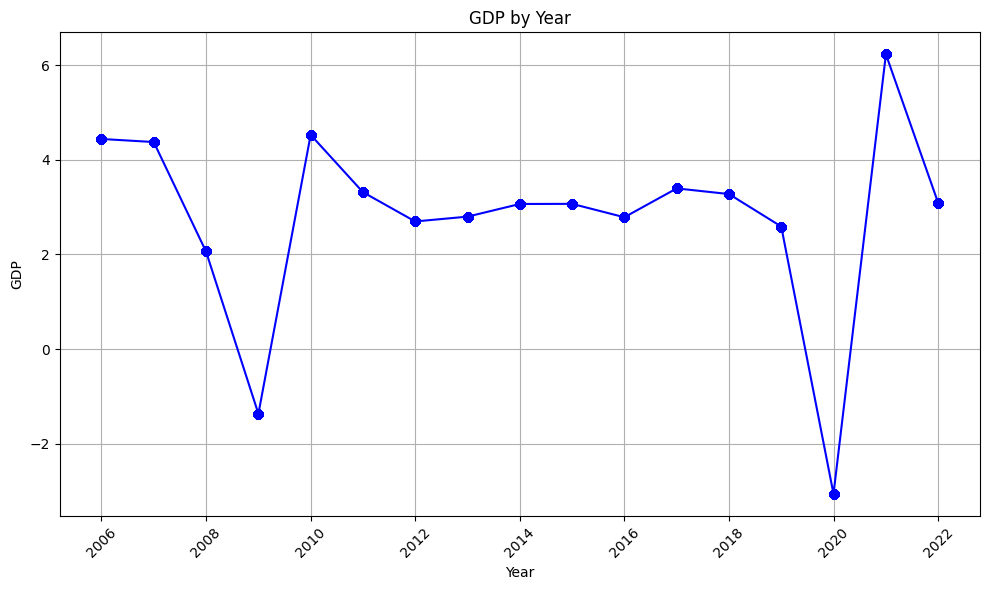

In [24]:
# Sort the DataFrame by 'Year' for proper plotting
df = df.sort_values('Year')

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['gdp'], marker='o', linestyle='-', color='b')
plt.title('GDP by Year')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to make sure everything fits without overlap
plt.show()